In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import numpy as np

This is a general $n$-bit diffuser defined by Qiskit in https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm

In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

We will be looking at the following 3-SAT of 5 clauses
$$
(\neg{v_1} \lor \neg{v_2} \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor v_3) \land (v_1 \lor v_2 \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor \neg{v_3}) \land (\neg{v_1} \lor v_2 \lor v_3)
$$
with solution set
$$
(T, F, T) = 101\\
(F, F, F) = 000 \\
(T, T, F) = 110 \\
$$

In [3]:
# Define quantum OR flipper
# This is technically the opposite of an OR
def OR(qc, vars, out):
    # Invert all inputs
    qc.x(vars[0])
    qc.x(vars[1])
    qc.x(vars[2])

    # Computer OR flip
    qc.mct(vars, out)

    # Flip back to original inputs
    qc.x(vars[0])
    qc.x(vars[1])
    qc.x(vars[2])

In [4]:
def add_clause(qc, clause, var_qubits, clause_qubit):
    # Flip the clause statement because qiskit orders qubits in reverse
    clause = clause[::-1]

    # Apply NOT gates to all variables that are negated in this clause
    for i in range(len(clause)):
        if clause[i] < 0:
            qc.x(var_qubits[i])

    # Apply OR gate
    OR(qc, var_qubits, clause_qubit)

    # Uncompute NOT gates
    for i in range(len(clause)):
        if clause[i] < 0:
            qc.x(var_qubits[i])

In [5]:
# Initialize circuit
var_qubits = QuantumRegister(3, name='v')    # One qubit per variable
clause_qubits = QuantumRegister(5, name='c') # One cubit per clause
out_qubit = QuantumRegister(1, name='out')   # Used to write output of clauses
cbits = ClassicalRegister(3, name='cbits')   # Three classical bits for output

qc = QuantumCircuit(var_qubits, clause_qubits, out_qubit, cbits)

# Initialize 'out' in state |->
qc.initialize([1, -1]/np.sqrt(2), out_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)

# Initialize clause qubits to 1
# The OR flipper will flip them to back 0/false if all the inputs are 0/false
qc.x(clause_qubits)

qc.barrier()  # for visual separation

In [6]:
# Add the first clause ( -v1 OR -v2 OR -v3 )
add_clause(qc, [-1, -1, -1], var_qubits, clause_qubits[0])

# Add second clause (v1 OR -v2 OR v3)
add_clause(qc, [1, -1, 1], var_qubits, clause_qubits[1])

# Add third clause (v1 OR v2 OR -v3)
add_clause(qc, [1, 1, -1], var_qubits, clause_qubits[2])

# Add fourth clause (v1 OR -v2 OR -v3)
add_clause(qc, [1, -1, -1], var_qubits, clause_qubits[3])

# Add fifth clause (-v1 OR v2 OR v3)
add_clause(qc, [-1, 1, 1], var_qubits, clause_qubits[4])

# Flip output if all clauses are satisfied
qc.mct(clause_qubits, out_qubit)

# Uncompute clauses to reset clause-checking bits to 0
add_clause(qc, [-1, -1, -1], var_qubits, clause_qubits[0])
add_clause(qc, [1, -1, 1], var_qubits, clause_qubits[1])
add_clause(qc, [1, 1, -1], var_qubits, clause_qubits[2])
add_clause(qc, [1, -1, -1], var_qubits, clause_qubits[3])
add_clause(qc, [-1, 1, 1], var_qubits, clause_qubits[4])

qc.barrier()



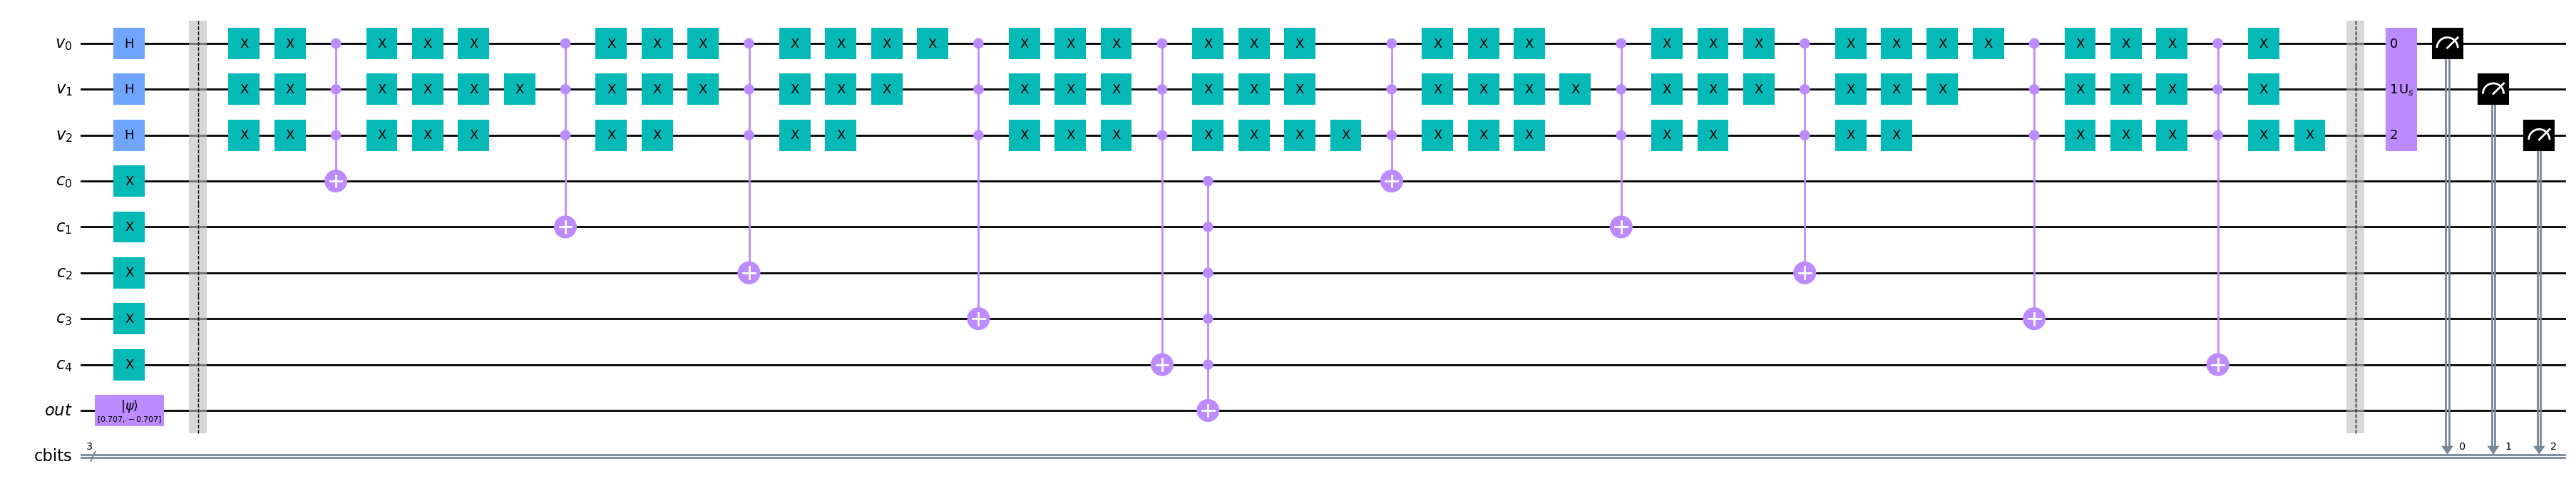

In [7]:
# Append diffuser
qc.append(diffuser(3), [0,1,2])

# Perform measurement
qc.measure(var_qubits, cbits)
qc.draw(output='mpl', fold=-1)

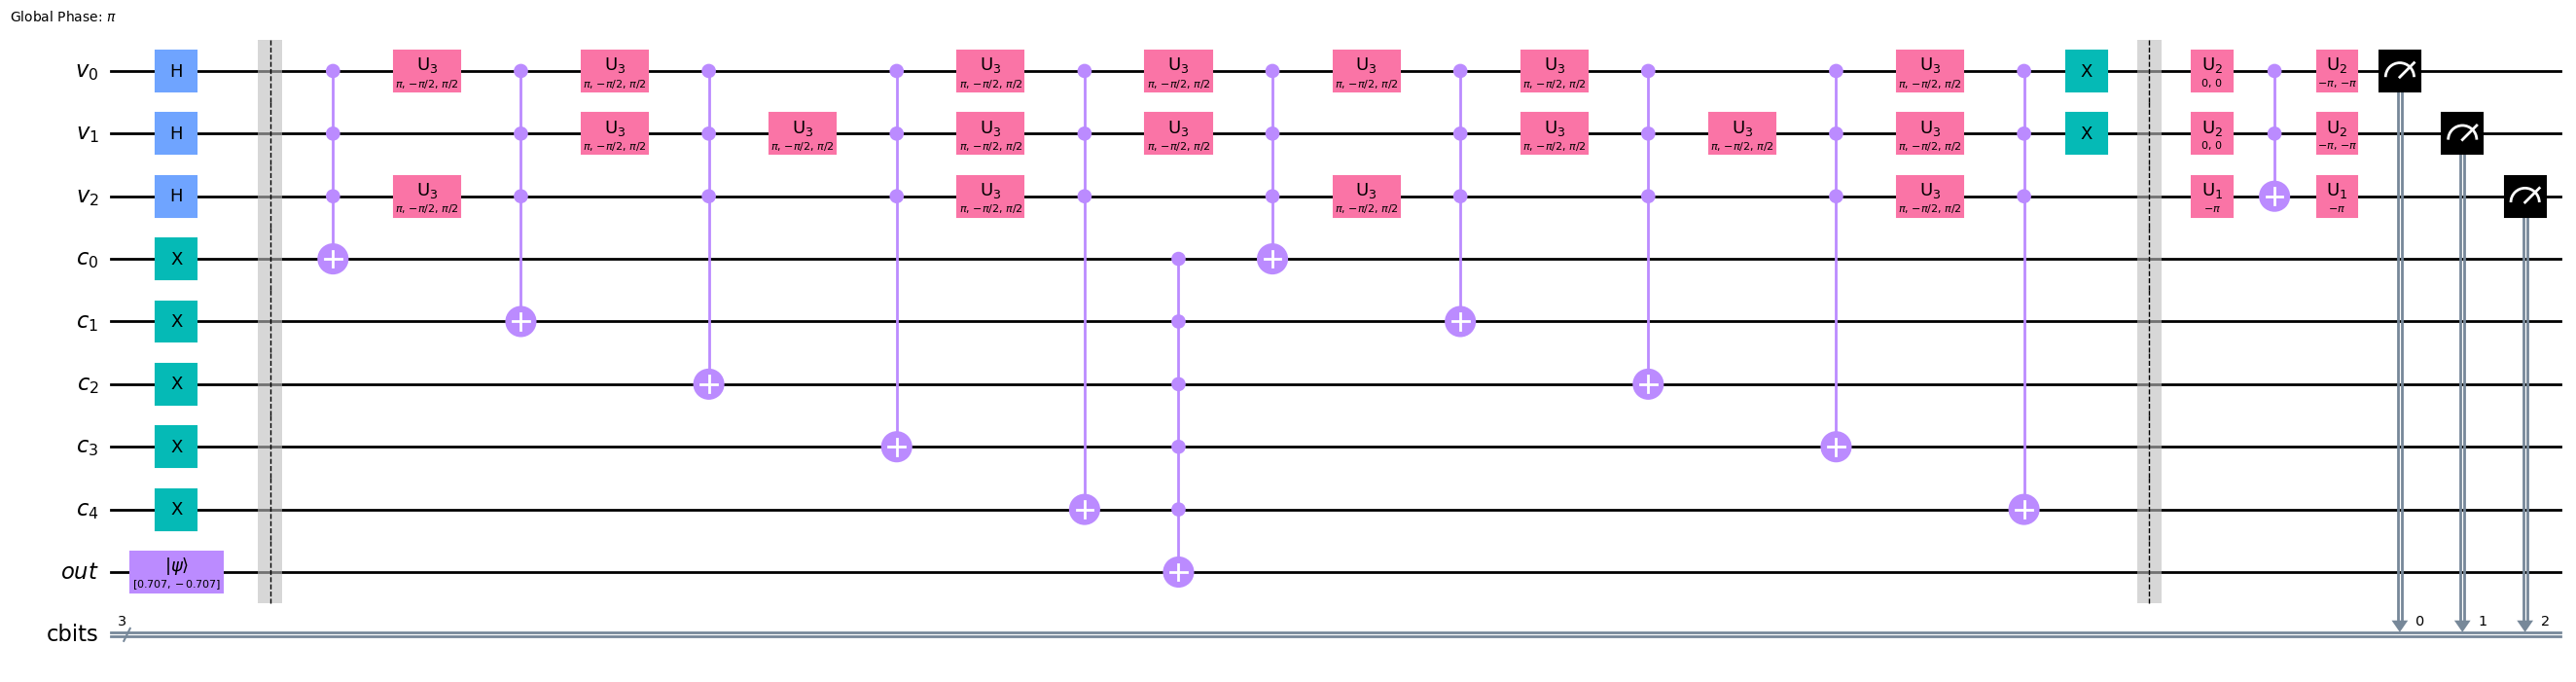

In [8]:
# Run on simulator
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
transpiled_qc.draw(output='mpl', fold=-1)

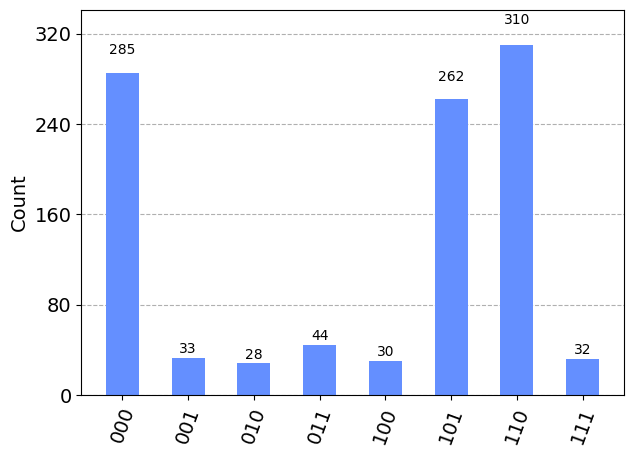

In [9]:
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

In [12]:
from qiskit_ibm_provider import IBMProvider
import os
from dotenv import load_dotenv

load_dotenv()
provider = IBMProvider(token=os.getenv('IBMQ_API_TOKEN'))

[<IBMBackend('ibm_algiers')>, <IBMBackend('ibm_cairo')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibm_nairobi')>]


In [13]:
print(provider.active_account())

[<IBMBackend('ibm_algiers')>, <IBMBackend('ibm_cairo')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibm_nairobi')>]
